In [4]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, accuracy_score

from commonsense_model import CommonsenseGRUModel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import pickle
import random

In [5]:
model_path = "best_model_iemocap.pt"
roberta_path = './example-sentences/example_sentences_features_roberta.pkl'
comet_path = './example-sentences/example_sentences_features_comet.pkl'

In [7]:
class DatasetLoader(Dataset):

    def __init__(self, roberta_path, comet_path):
        '''
        label index mapping = {'hap':0, 'sad':1, 'neu':2, 'ang':3, 'exc':4, 'fru':5}
        '''
        self.speakers, self.roberta1, self.roberta2, self.roberta3, self.roberta4,\
        self.sentences, self.ids = pickle.load(open(roberta_path, 'rb'), encoding='latin1')
        
        self.xIntent, self.xAttr, self.xNeed, self.xWant, self.xEffect, self.xReact, self.oWant, self.oEffect, self.oReact \
        = pickle.load(open(comet_path, 'rb'), encoding='latin1')

        self.keys = self.ids
        
        self.len = len(self.keys)
        self.labels = {}
        for key in self.speakers:
            self.labels[key] = [0] * len(self.speakers[key])


    def __getitem__(self, index):
        vid = self.keys[index]
        return torch.FloatTensor(self.roberta1[vid]),\
               torch.FloatTensor(self.roberta2[vid]),\
               torch.FloatTensor(self.roberta3[vid]),\
               torch.FloatTensor(self.roberta4[vid]),\
               torch.FloatTensor(self.xIntent[vid]),\
               torch.FloatTensor(self.xAttr[vid]),\
               torch.FloatTensor(self.xNeed[vid]),\
               torch.FloatTensor(self.xWant[vid]),\
               torch.FloatTensor(self.xEffect[vid]),\
               torch.FloatTensor(self.xReact[vid]),\
               torch.FloatTensor(self.oWant[vid]),\
               torch.FloatTensor(self.oEffect[vid]),\
               torch.FloatTensor(self.oReact[vid]),\
               torch.FloatTensor([[1,0] if x=='M' else [0,1] for x in self.speakers[vid]]),\
               torch.FloatTensor([1]*len(self.speakers[vid])),\
               torch.LongTensor(self.labels[vid]),\
               vid
               

    def __len__(self):
        return self.len

    def collate_fn(self, data):
        dat = pd.DataFrame(data)
        return [pad_sequence(dat[i]) if i<14 else pad_sequence(dat[i], True) if i<16 else dat[i].tolist() for i in dat]

In [13]:
def dataloader(roberta_path, comet_path):
    testset = DatasetLoader(roberta_path, comet_path)
    test_loader = DataLoader(testset,
                             batch_size=32,
                             collate_fn=testset.collate_fn,
                             num_workers=0,
                             pin_memory=False)
    return test_loader


## Evaluation Function

In [14]:
def eval_model(model, dataloader):
    preds, labels, masks  = [], [], []
    alphas, alphas_f, alphas_b, vids = [], [], [], []
    log_probs = []
  
    model.eval()

    # seed_everything(seed)
    for data in dataloader:     
        r1, r2, r3, r4, \
        x1, x2, x3, x4, x5, x6, \
        o1, o2, o3, \
        qmask, umask, labels= data[:-1]
        log_prob, _, alpha, alpha_f, alpha_b, _ = model(r1, r2, r3, r4, x5, x6, x1, o2, o3, qmask, umask, att2=True)
        log_probs.append(log_prob)
        lp_ = log_prob.transpose(0,1).contiguous().view(-1, log_prob.size()[2]) # batch*seq_len, n_classes

        pred_ = torch.argmax(lp_,1) # batch*seq_len
        preds.append(pred_.data.cpu().numpy())
        masks.append(umask.view(-1).cpu().numpy())
        
        
        alphas += alpha
        alphas_f += alpha_f
        alphas_b += alpha_b
        vids += data[-1]
        break

    if preds!=[]:
        preds  = np.concatenate(preds)
        masks  = np.concatenate(masks)
    else:
        return float('nan'), float('nan'), float('nan'), [], [], [], float('nan'),[]

    
    return preds, masks, [alphas, alphas_f, alphas_b, vids], log_probs

## Loading the Model

In [15]:
D_m = 1024
D_s = 768
D_g = 150
D_p = 150
D_r = 150
D_i = 150
D_h = 100
D_a = 100
D_e = D_p + D_r + D_i

model = CommonsenseGRUModel(D_m, D_s, D_g, D_p, D_r, D_i, D_e, D_h, D_a,
                                n_classes=6,
                                listener_state=True,
                                context_attention="general2",
                                dropout_rec=0.1,
                                dropout=0.25,
                                emo_gru=True,
                                mode1=2,
                                norm=3,
                                residual=False)
model.load_state_dict(
    torch.load(model_path, map_location=torch.device("cpu"))
)

<All keys matched successfully>

In [16]:
test_loader = dataloader(roberta_path, comet_path)
'''
label index mapping = {'hap':0, 'sad':1, 'neu':2, 'ang':3, 'exc':4, 'fru':5}
'''
preds, masks, _, log_probs = eval_model(model=model, dataloader=test_loader)

In [17]:
preds

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 1, 5, 2, 5, 5, 1, 1, 1, 1])

## Plotting Functions

In [19]:
def map_probs(speakers, probs, emotion):  
    speaker_x1 = []
    speaker_x2 = []  
    speaker_1_probs = []
    speaker_2_probs = []
    for i, prob in enumerate(probs[:len(speakers), :, emotion]):
        if speakers[i] == 'M':
            speaker_x1.append(i)
            speaker_1_probs.append(prob.item())
        else:
            speaker_x2.append(i)
            speaker_2_probs.append(prob.item())
    return speaker_1_probs, speaker_2_probs, speaker_x1, speaker_x2


In [20]:
def plot_emotions_1(dialogue_number, dialogue_probs, speakers_dict):    
    emo_mapping = {0: 'hap', 1: 'sad', 2: 'neu', 3: 'ang', 4: 'exc', 5: 'fru'}
    plt.figure(figsize=(10, 5)) # layout="tight"
    plt.rcParams.update({'font.size': 8})

    speaker_keys = list(speakers_dict.keys())

    for i in range(6):
        speaker_1_probs, speaker_2_probs, speaker_x1, speaker_x2 = map_probs(speakers_dict[speaker_keys[dialogue_number-1]], dialogue_probs, i)
        plt.subplot(2, 3, i+1)
        plt.title(f'Emotion: {emo_mapping[i]}')
        plt.plot(speaker_x1, speaker_1_probs, color='#27aeef') 
        plt.plot(speaker_x2, speaker_2_probs, color='#edbf33')  
        plt.legend(['Speaker 1', 'Speaker 2'])
        plt.xlabel('Time')
        plt.ylabel('Log Probability')
    plt.suptitle(f'Dialogue {dialogue_number}')
    plt.show()

In [21]:
def plot_emotions_2(dialogue_probs, speakers):    
    emo_color_mapping = {0: '#50af50', 1: '#0b5394', 2: 'gray', 3: '#f44336', 4: '#f1cc32', 5: '#ff912a'}
    emo_mapping = {0: 'hap', 1: 'sad', 2: 'neu', 3: 'ang', 4: 'exc', 5: 'fru'}
    plt.rcParams.update({'font.size': 10})
    plt.figure(figsize=(10, 6))
    plt.xlabel('Time')
    plt.ylabel('Log Probability')
    for i in range(6):
        speaker_1_probs, speaker_2_probs, speaker_x1, speaker_x2 = map_probs(speakers, dialogue_probs, i)
        plt.plot(speaker_x1, speaker_1_probs, marker='s', color=emo_color_mapping[i], markersize=7, label=f'S1: {emo_mapping[i]}') 
        plt.plot(speaker_x2, speaker_2_probs, marker='v', color=emo_color_mapping[i], markersize=7, label=f'S2: {emo_mapping[i]}')  
        
    # lines = [mlines.Line2D([], [], color=emo_color_mapping[i], label=emo_mapping[i]) for i in emo_mapping]
    # lines += [mlines.Line2D([], [], marker='s')]
    plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=2)

    plt.suptitle(f'Dialogue', fontsize='large', fontweight='bold')
    plt.show()

In [22]:
def plot_sentences(sentences, predictions, speakers):
    label_index_mapping = {'hap':0, 'sad':1, 'neu':2, 'ang':3, 'exc':4, 'fru':5}
    emotion_label_mapping = list(label_index_mapping.keys())
    fig = plt.figure(figsize=(10, 15))
    ax = fig.add_subplot()
    fig.subplots_adjust(top=0.85)


    ax.set_title("Sentences and Preds")
    ax.axis("off")
    ax.axis([0, 40, 0, 40])

    for i, sentence in enumerate(sentences):
        # true_lab = emotion_label_mapping[true_labels[i]]
        ax.text(
            1,
            38 - i*1.2,
            f"Speaker: {speakers[i]} : {sentence} (Pred: {emotion_label_mapping[predictions[i]]})",
            fontsize=10,
            # color=color_mapping_emotions[label_index_mapping[true_lab]]
        )

## Results

In [33]:
random_data = pickle.load(open(roberta_path, 'rb'))
speakers_dict = random_data[0]
speaker_keys = list(speakers_dict.keys())
num_keys = len(speaker_keys)
speaker_keys

['es_1', 'es_2', 'es_3']

In [35]:
dialogue_1_probs, dialogue_2_probs, dialogue_3_probs = torch.chunk(log_probs[0], num_keys, 1)
max_seq_length = dialogue_1_probs.size()[0]
max_seq_length

21

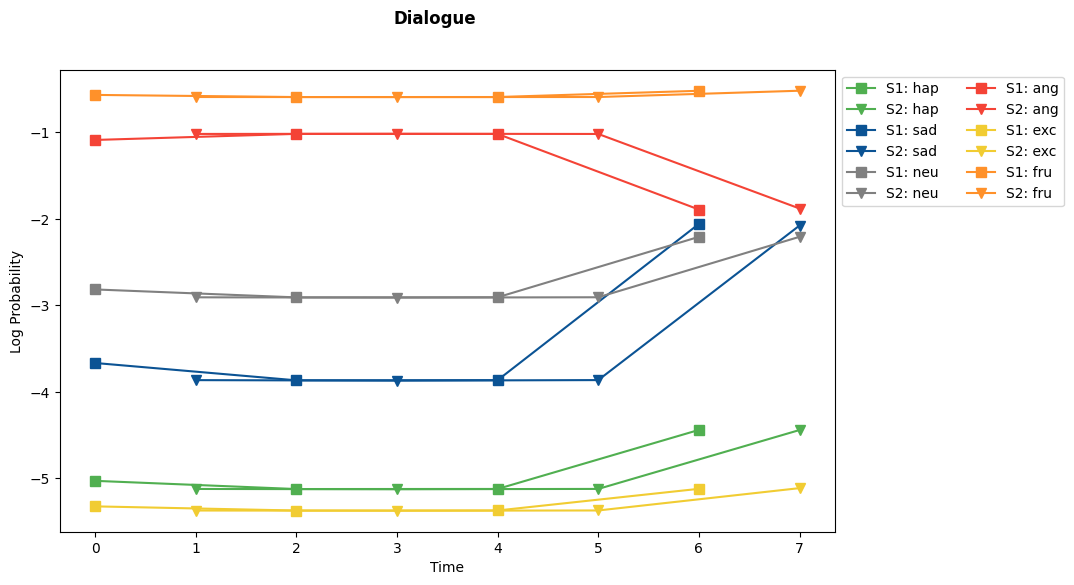

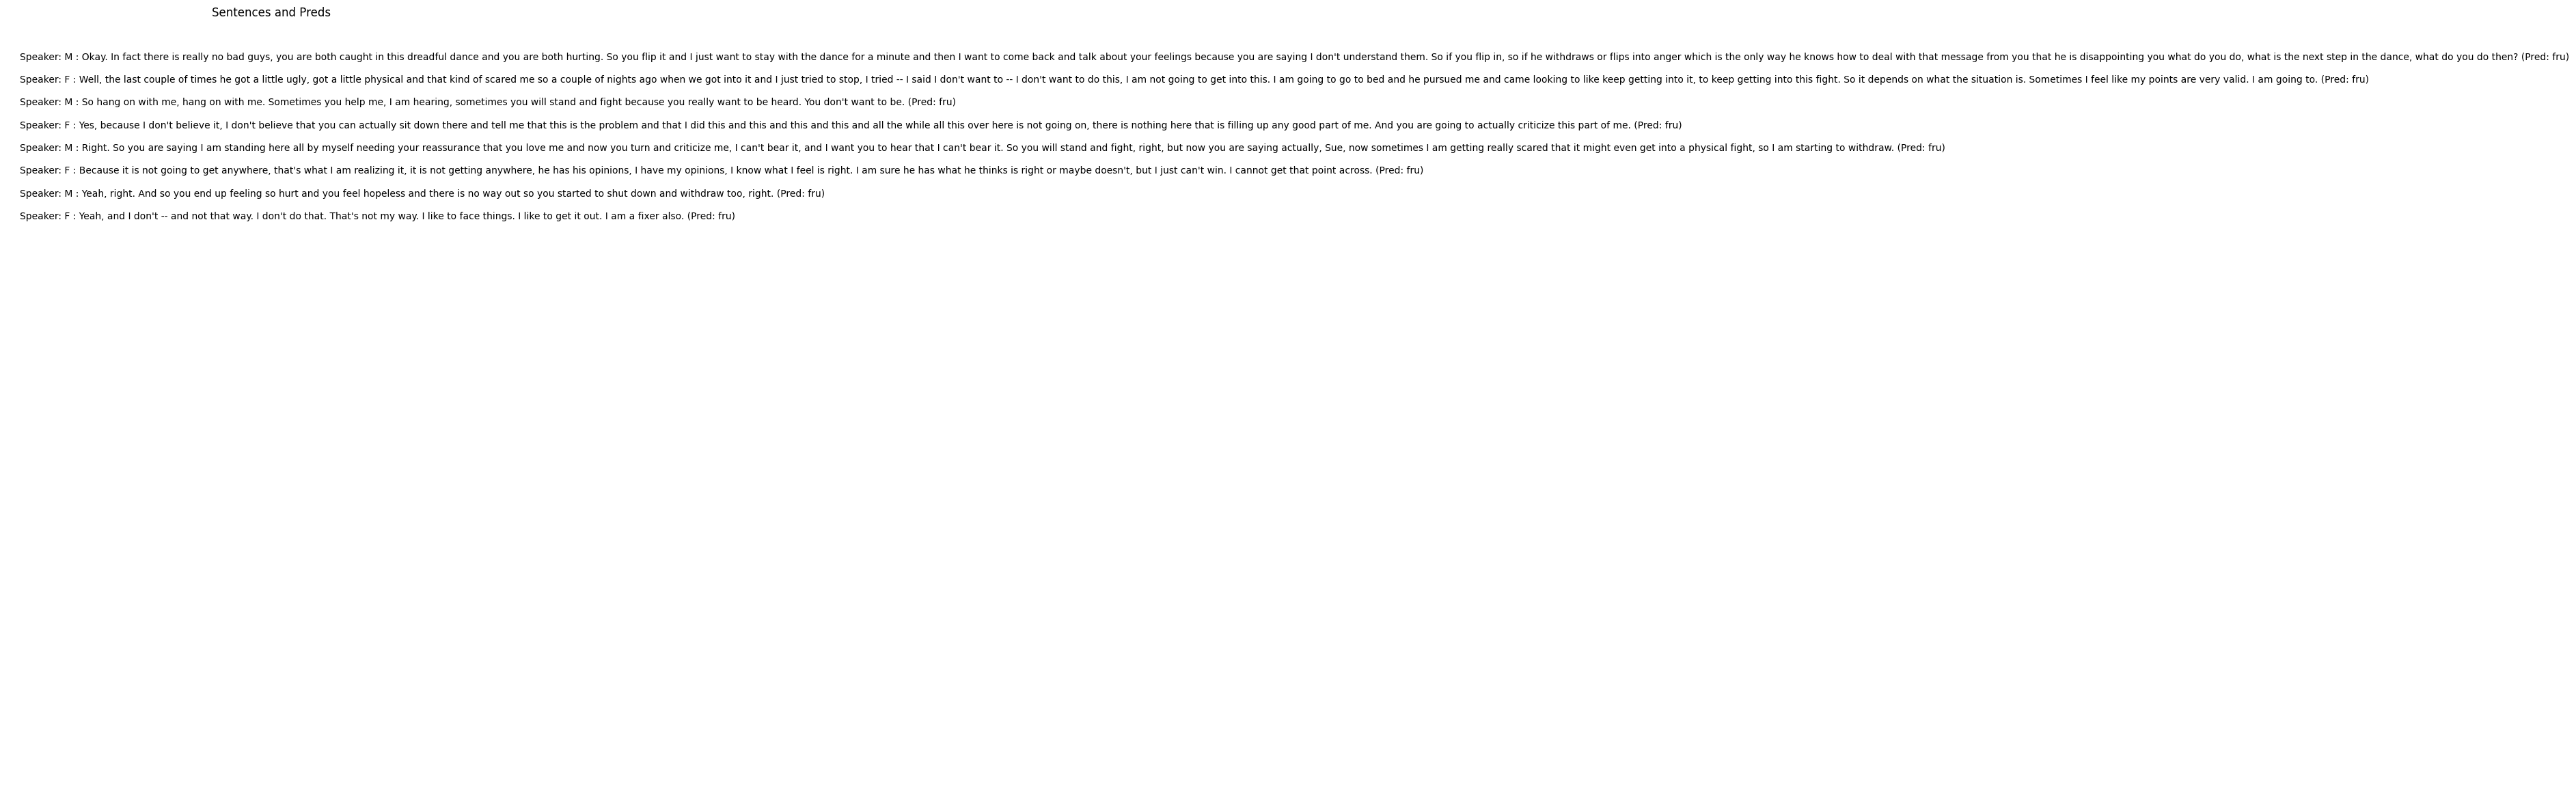

In [38]:
sentences_1 = random_data[5][speaker_keys[0]]
predictions_1 = preds[:max_seq_length]
dialogue_1_speakers = speakers_dict[speaker_keys[0]]
plot_emotions_2(dialogue_1_probs, dialogue_1_speakers)
plot_sentences(sentences_1, predictions_1, dialogue_1_speakers)

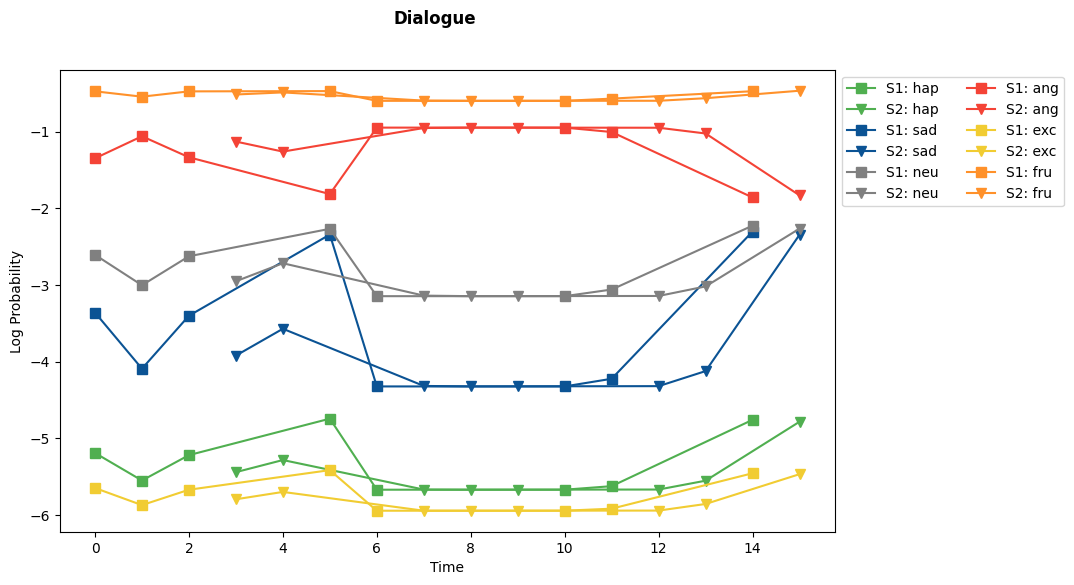

In [31]:
dialogue_2_speakers = speakers_dict[speaker_keys[1]]
plot_emotions_2(dialogue_2_probs, dialogue_2_speakers)

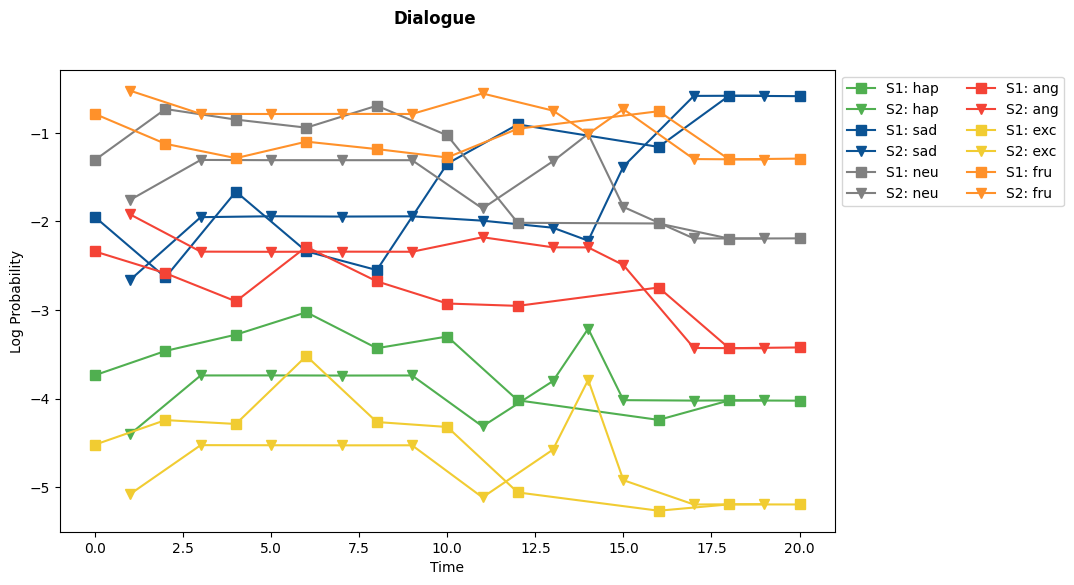

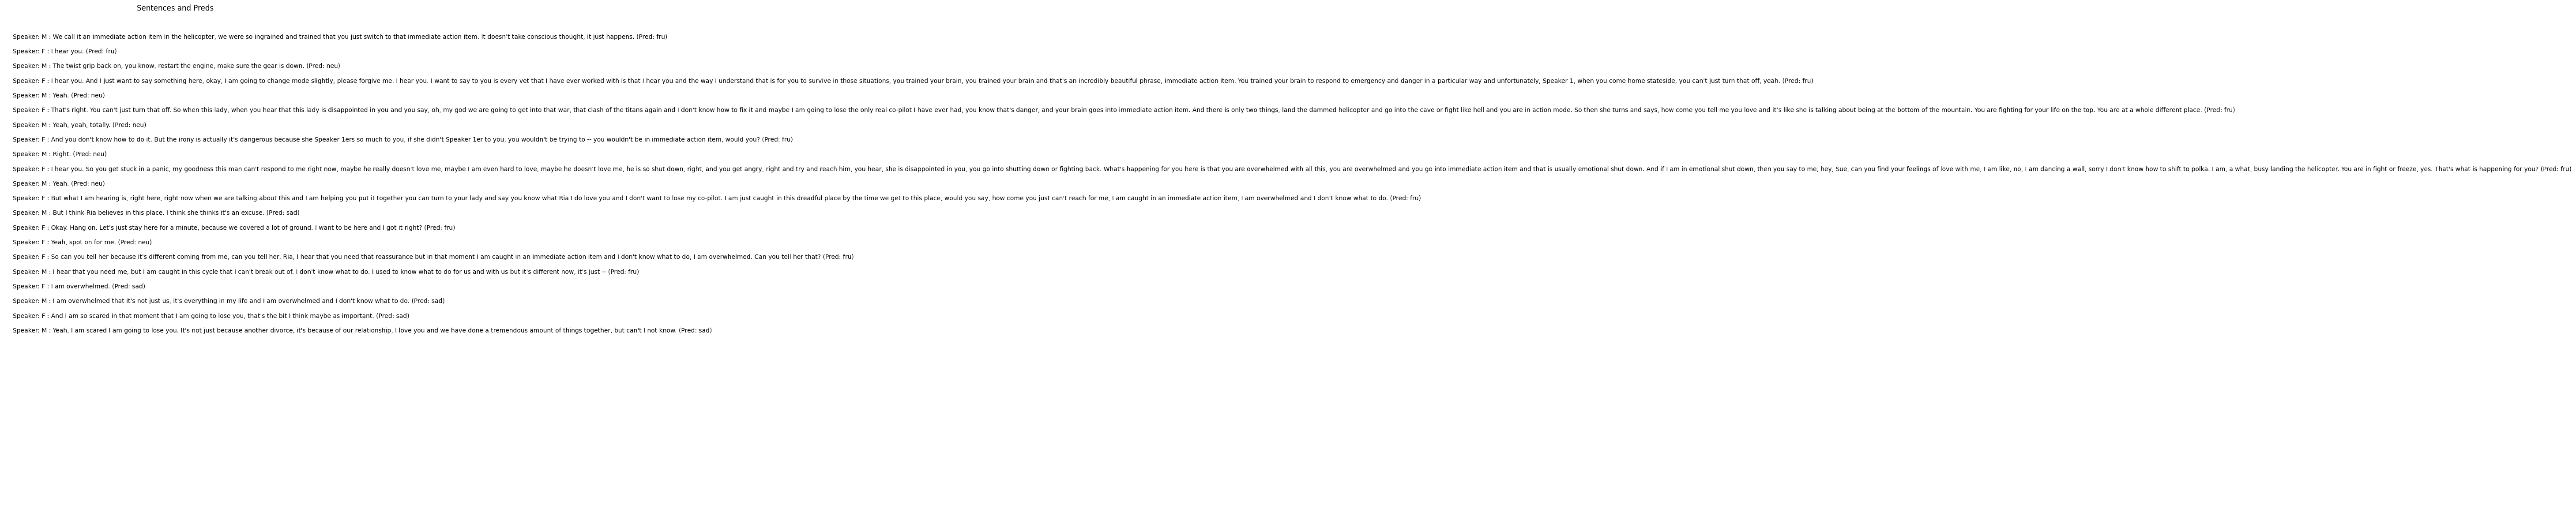

In [39]:
sentences_3 = random_data[5][speaker_keys[2]]
predictions_3 = preds[-max_seq_length:]
dialogue_3_speakers = speakers_dict[speaker_keys[2]]
plot_emotions_2(dialogue_3_probs, dialogue_3_speakers)
plot_sentences(sentences_3, predictions_3, dialogue_3_speakers)

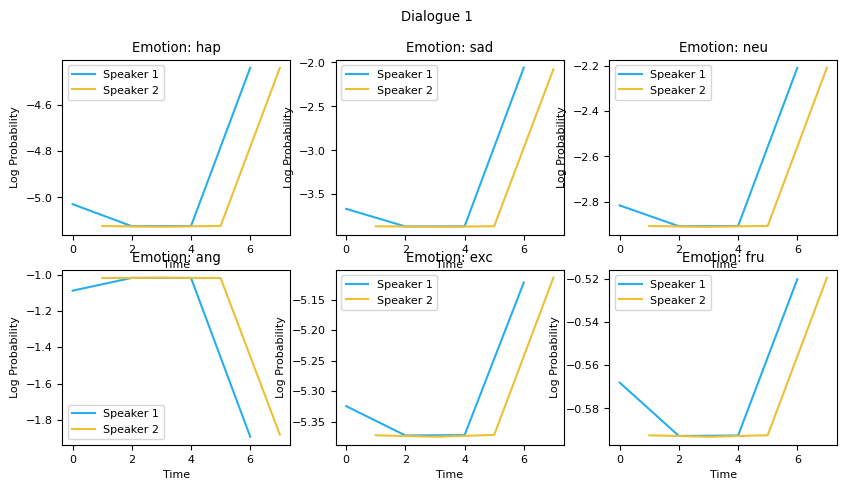

In [84]:
plot_emotions_1(1, dialogue_1_probs, speakers_dict)

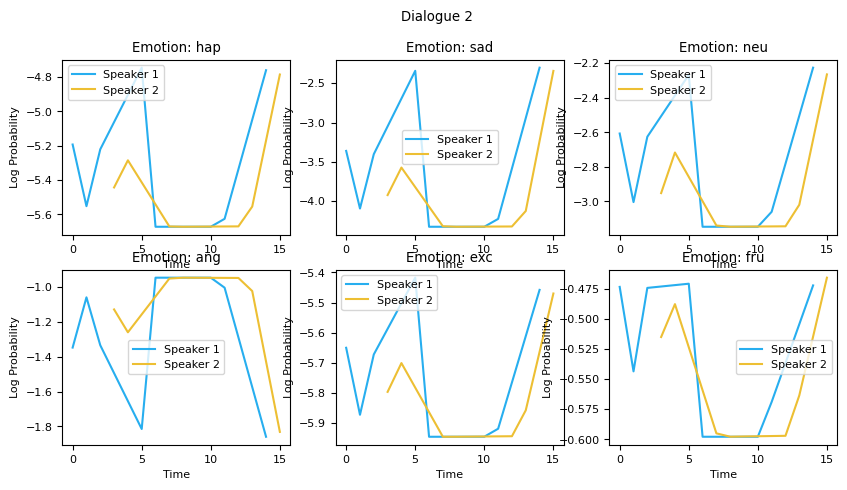

In [85]:
plot_emotions_1(2, dialogue_2_probs, speakers_dict)

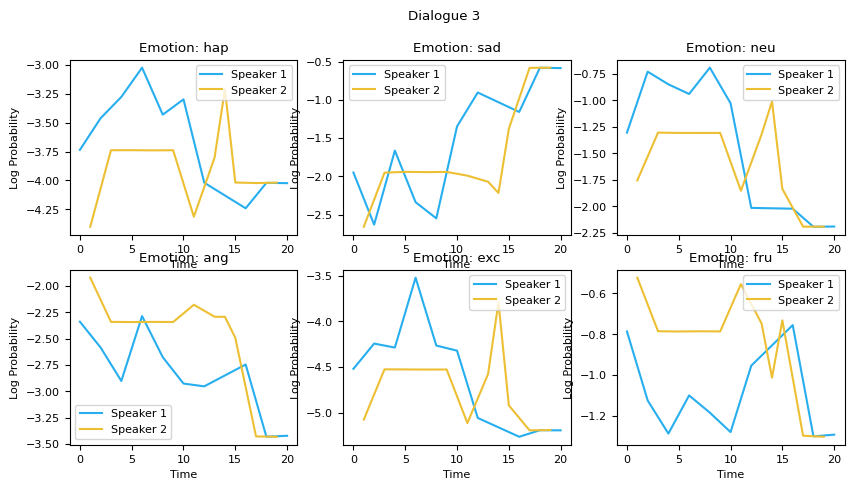

In [40]:
plot_emotions_1(3, dialogue_3_probs, speakers_dict)